## Purpose
Purpose of this notebook is to quickly train a image classifier that is able to distinguish between images of cats and dogs and achieve some acceptable degree of performance (a binary classification problem). Accuracy will be used to evaluate the performance and we'll train a simple CNN to classify the images.

In order to not make this notebook too lengthy, some helper functions are defined in the [utils.py](utils.py), feel free to check it out.

## Libraries

In [162]:
import os
from utils import *
%matplotlib inline
%reload_ext autoreload
%autoreload 2

## Dataset preparation
The image data we're going to use is [Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats/data) dataset available on [Kaggle](https://www.kaggle.com/) which contain 25,000 images of dogs and cats. You may need a Kaggle account to download the dataset on your local machine. The training set and test set  will be stored under ```datasets/train``` and ```datasets/test1``` subdirectories respectively.

In [109]:
TRAIN_DIR = 'datasets/train/'
TEST_DIR = 'datasets/test1'
print("Number of training images: {}".format(len(os.listdir(TRAIN_DIR))))
print("Number of test images: {}".format(len(os.listdir(TEST_DIR))))

Number of training images: 25000
Number of test images: 12500


### Load the dataset and resize the images
The dataset will include two parts:
- X: the actual images transformed to ndarray
- y: corresponding labels, where ```label = 0``` for dog images and ```label = 1``` for cat images.

Notice that there are 25,000 images in total available for training, but we will just use a subset of it like 5,000 images to speed up training phase. Also resize the images' height and width to 300.

In [181]:
dataset_size = 5000

In [182]:
%%time
X, y = load_image_dataset(dataset_size=dataset_size, size=(300, 300))
print(X.shape, y.shape)

(5000, 300, 300, 3) (5000, 1)
CPU times: user 38.5 s, sys: 2.23 s, total: 40.7 s
Wall time: 57.5 s


### Inspect images in the dataset

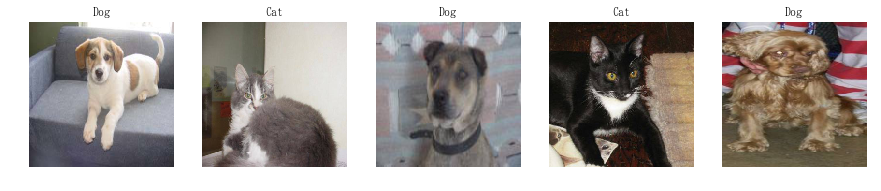

In [183]:
num_samples = 5
show_images_horizontally(X[:num_samples], y[:num_samples], figsize=(15, 10),
                         lookup_label={0: 'Dog', 1: 'Cat'})

### Normalization
To represent color images, the red, green and blue channels (RGB) must be specified for each pixel, and so the pixel value is actually a vector of three numbers ranging from 0 to 255.

One common preprocessing step in machine learning is to **center and standardize** your dataset, meaning that you substract the mean of the whole numpy array from each example, and then divide each example by the standard deviation of the whole numpy array. But for **picture** datasets, it is simpler and more convenient and works almost as well to just divide every row of the dataset by 255 (the maximum value of a pixel channel).

In [193]:
X = X / 255

Although there seems no difference after normlization.

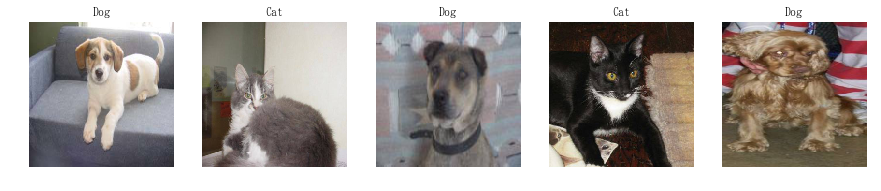

In [194]:
num_samples = 5
show_images_horizontally(X[:num_samples], y[:num_samples], figsize=(15, 10),
                         lookup_label={0: 'Dog', 1: 'Cat'})

### Build training / validation set
It's a good practice to make a subset of dataset as validation set and tuning our models before actually test their performance on the test set. Because the order of images in the dataset are already randomized (by randomly pick images in the folder), we can just separate the dataset into training set / validation set in the ratio of (0.7, 0.3).

In [196]:
train_set_ratio = 0.7
idx = int(dataset_size * train_set_ratio)
train_X, train_y, valid_X, valid_y = X[:idx], y[:idx], X[idx:], y[idx:]
del X, y # tips to save memory

Training set: (3500, 300, 300, 3), (3500, 1)
Validation set: (1500, 300, 300, 3), (1500, 1)


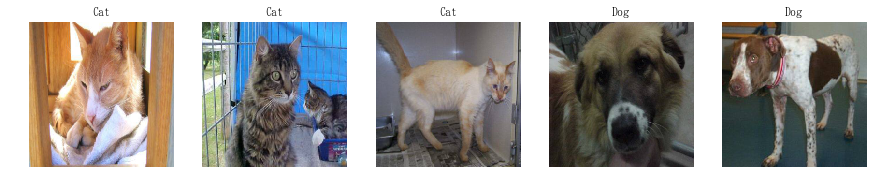

In [197]:
print('Training set: {}, {}'.format(train_X.shape, train_y.shape))
print('Validation set: {}, {}'.format(valid_X.shape, valid_y.shape))
show_images_horizontally(valid_X[:num_samples], valid_y[:num_samples], figsize=(15, 10),
                         lookup_label={0: 'Dog', 1: 'Cat'})

### Class distribution in dataset
Make sure the distribution of training/validation set are similar and there is no serious unbalanced class problem.

In [198]:
train_cat, valid_cat = train_y == 1, valid_y == 1
print('{:.1f}% images in training set are cats'.format(len(train_y[train_cat]) / len(train_y) * 100))
print('{:.1f}% images in validation set are cats'.format(len(valid_y[valid_cat]) / len(valid_y) * 100))

50.0% images in training set are cats
49.3% images in validation set are cats


Seems that we're good to proceed.

normalization
data augmentation

## Build model

### Computation graph

### Train the model